# Bike accident analysis in Madrid city (2018-2020)

Following the Coursera course I'm in I wanted to practice with some real data out there. What best to get some insights about the city I live in ? Nowadays I normally ride my bike several days a week through the city and I was curious about the bike accidents in the city. Here are the source datasets I'm using during this analysis.

- [Source Madrid Open Data](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=7c2843010d9c3610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default) 
- From the available datasets I'm using the years 2018, 2019, and 2020 (until August which is the last available dataset at the time of writing). 

I've realized that conducting an analysis using a Jupyter Notebook is great not only because is one of the best tools for statistical analysis but also because I can export the notebook to asciidoc which I can convert easily to asciidoctor and copy/paste it to my blog.

Before doing any kind of analysis we need to look the data and see if we should clean it up a little bit.

## 2018 Dataset

Datasets before 2018 have a different formatting that datasets from 2019 and ahead. Therefore I need to make them match the rest of the datasets I'm merging it with.

In [1]:
import pandas as pd

def get_first_hour(hour_range_str):
    import re
    m = re.search('DE (.*) A .*', hour_range_str)
    return m.group(1)

accidents_2018 = pd.read_csv("accidents_2018.csv", delimiter=";", skiprows=0, encoding="ISO-8859-1")

accidents_2018["TIPO VEHÍCULO"] = accidents_2018["Tipo Vehiculo"]
accidents_2018["CALLE"] = accidents_2018["LUGAR ACCIDENTE"]
accidents_2018["HORA"] = accidents_2018["RANGO HORARIO"].apply(get_first_hour)

## 2019-2020 Datasets

Reading 2019 and 2020 CSV files.

In [2]:
accidents_2020 = pd.read_csv("accidents_2020.csv", delimiter=";", skiprows=0, encoding="ISO-8859-1")
accidents_2019 = pd.read_csv("accidents_2019.csv", delimiter=";", skiprows=0, encoding="ISO-8859-1")

## Merging datasets 2018-2020

Finally merging all datasets into the dataframe I'll be working with.

In [3]:
accidents=pd.concat([accidents_2018, accidents_2019, accidents_2020])

## Preparing DataFrame to start with the analysis

Before starting with the analysis there're a couple of steps required to make the process a little bit easier:

- I'm interested only in **a given set of columns**: "FECHA", "HORA", "CALLE", "DISTRITO", "TIPO VEHÍCULO".

In [4]:
columns_to_keep = ["FECHA", "HORA", "CALLE", "DISTRITO", "TIPO VEHÍCULO"]
accidents = accidents[columns_to_keep].dropna()

- I'm only interested in **bike accidents**:

In [5]:
by_bike = accidents["TIPO VEHÍCULO"].str.startswith("Moto") | \
    accidents["TIPO VEHÍCULO"].str.startswith("Ci") | \
    accidents["TIPO VEHÍCULO"].str.startswith("MO")

accidents = accidents[by_bike]
accidents.drop("TIPO VEHÍCULO", axis=1, inplace=True)

- I need to normalize **street names**:

In [6]:
accidents["CALLE"] = accidents["CALLE"].\
    str.replace("CALLE DE", "").\
    str.replace("CALLE", "").\
    str.replace("NUM .*", "").\
    str.replace("CALL. ", "").\
    str.replace(" - .*", "").\
    str.strip()

- I need to normalize **district names** as well.

In [7]:
for x, y in [('Á', 'A'), ('Í', 'I')]:
    accidents["DISTRITO"] = accidents["DISTRITO"].\
        str.replace(x, y).\
        str.strip()

- **Convert string dates** to actual timestamp objects

In [8]:
accidents["TIMESTAMP"] = accidents["FECHA"] + " " + accidents["HORA"]
accidents["TIMESTAMP"] = pd.to_datetime(accidents["TIMESTAMP"], format="%d/%m/%Y %H:%M")

- **Sort DataFrame by date** in ascending order

In [9]:
accidents = accidents.sort_values("TIMESTAMP")
accidents = accidents.reset_index()
accidents.drop(["FECHA", "HORA", "index"], axis=1, inplace=True)
accidents.head()

,CALLE,DISTRITO,TIMESTAMP
0,VIA CARPETANA,CARABANCHEL,2018-01-01 21:00:00
1,LA INFANTA MERCEDES,TETUAN,2018-01-02 12:00:00
2,LA ARMADA ESPAÑOLA,SALAMANCA,2018-01-02 13:00:00
3,EUGENIO SALAZAR,CHAMARTIN,2018-01-02 14:00:00
4,PASEO DE LA CASTELLANA,CHAMBERI,2018-01-02 15:00:00


## Analysis

### Accident trend

In this first question I'd like to address the following points:

- **Answer the question**: Are the number of accidents increasing from 2018 ?  
- **Show a line chart** showing the trend

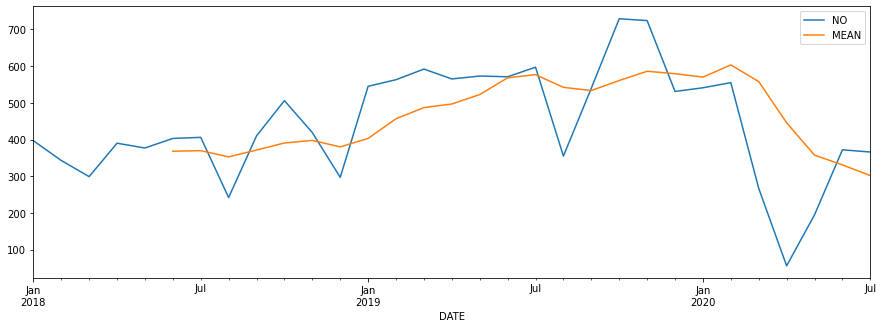

In [10]:
trends = accidents.copy()
trends["NO"] = 1
trends["MONTH"] = trends["TIMESTAMP"].dt.strftime("%m")
trends["YEAR"] = trends["TIMESTAMP"].dt.strftime("%Y")
trends = trends.set_index(["YEAR", "MONTH"])
trends = trends.groupby(["YEAR", "MONTH"]).sum()
trends = trends.reset_index()
trends["DATE"] = trends["YEAR"] + "/" + trends["MONTH"]
trends["DATE"] = pd.to_datetime(trends["DATE"], format="%Y/%m")

# getting rid of unnecessary columns
trends.drop(["YEAR", "MONTH"], axis=1, inplace=True)

# rolling mean
trends["MEAN"] = trends["NO"].rolling(6).mean()
trends = trends.set_index("DATE")

trends.plot.line(figsize=(15,5))

- Visually the first thing that sprang to mind was **the huge abism on april 2020** because of the **covid-19 confinement** in Spain. 
- Despite that important fact, is also true that **the general trend from 2018 was increasing significantly until october 2019**. You can see the rolling mean (in yellow) going up until later 2019.

There are **two patterns** worth mentioning:

- **A decrease** of accidents at holidays' peaks (August/December)
- **An increase** at the end of of holidays (end of August and earlier January)

You can see the increase/decrease percentage in the next dataframe.

In [11]:
percent = accidents.copy()

percent["NO"] = 1
percent["YEAR"] = percent["TIMESTAMP"].dt.year
percent = percent.groupby("YEAR").aggregate("sum").head()

percent = percent.reset_index()
percent = percent.rename(columns={"NO": "TOTAL"}, inplace=False)

for i in range(1, len(percent)):
    previous = percent.loc[i-1, "TOTAL"]
    current = percent.loc[i, "TOTAL"]
    percent.loc[i, "INCREMENT"] = ((current - previous) / previous) * 100
    
percent

,YEAR,TOTAL,INCREMENT
0,2018,4489,NaN
1,2019,6885,53.374916
2,2020,2352,-65.838780


### Worst districts by number of accidents

The worst ten district by number of accidents during these three years were:

In [12]:
wb = accidents.copy()
wb["NO"] = 1
wb = wb.\
    groupby("DISTRITO").\
    sum().\
    sort_values("NO", ascending=False)
    
wb.head(10)

,NO
DISTRITO,
SALAMANCA,1517
CENTRO,1276
CHAMBERI,1264
CHAMARTIN,1250
TETUAN,998
CIUDAD LINEAL,873
RETIRO,776
MONCLOA-ARAVACA,699
ARGANZUELA,648


### Comparing the wost distrinct vs the best

The most dangerous district vs the safest. It turns out the district with **the highest rate of accidents** was the district of **SALAMANCA** whereas **the lowest was VICALVARO**. It makes sense because VICALVARO is outside the city center by far, so traffic density is also very low.

In [13]:
wb = wb.iloc[[0, -1]]
wb

,NO
DISTRITO,
SALAMANCA,1517
VICALVARO,117


### When is the best/worst hours to ride in general ? 

Apart from the districts it would be nice to know which are the best/worst moment to get out there with your bike. Although we will see how rush hours are in general a bad moment to go, it seems that **the worst hour to ride in general is 14h**, is when most accidents occur. On the other hand, **the hour with less number of accidents is 4h**, which makes sense because at that hour at night you don't see a soul on the road.

In [14]:
hs = accidents.copy()

hs["HOUR"] = hs["TIMESTAMP"].dt.hour
hs["DAY"] = hs["TIMESTAMP"].dt.dayofweek

hs = hs.\
    groupby(["DAY", "HOUR"]).\
    size().\
    reset_index(name="COUNT").\
    set_index("DAY")

all_week = pd.DataFrame(hs.reset_index().groupby("HOUR")["COUNT"].sum())
values = all_week.sort_values("COUNT")

worst = values.iloc[-1]
best  = values.iloc[0]

w_hour, w_no, b_hour, b_no = [worst.name, worst["COUNT"], best.name, best["COUNT"]]

message = "Best \t==> {}h  ({} accidents)\nWorst \t==> {}h ({} accidents)".format(b_hour, b_no, w_hour, w_no)
print(message)

Best 	==> 4h  (60 accidents)
Worst 	==> 14h (1060 accidents)


### Analysis of hours during the week

I'd to see visually how accidents are arrange on a working day. In order to achieve that I'm creating a bar chart with the aggregated number of accidents from Monday to Friday by hour.

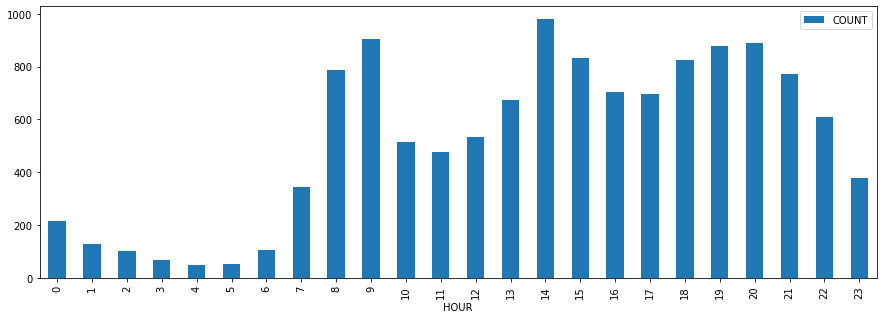

In [15]:
week = hs.loc[0:5]
week = pd.DataFrame(week.reset_index().groupby("HOUR")["COUNT"].sum())

week.plot.bar(y="COUNT", figsize=(15,5))

### Analysis of hours during the weekend

As a biker, it's even more important to me to analyse when is the best moment to ride my bike during the weekends. So the same way I did the analysis for the working days, here I'm doing the same for the weekend.

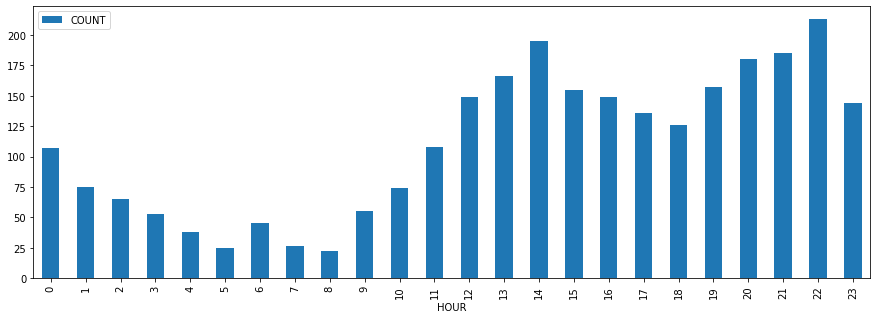

In [16]:
weekend = hs.loc[5:7]
weekend = pd.DataFrame(weekend.reset_index().groupby("HOUR")["COUNT"].sum())

weekend.plot.bar(y="COUNT", figsize=(15,5))

### Comparing week/weekend hour by hour

Fortunately the number of accidents decreases a lot during weekends, but the shape of the chart seems to be pretty similar. I'm curious to see both charts head to head to see both datasets with the same scale.

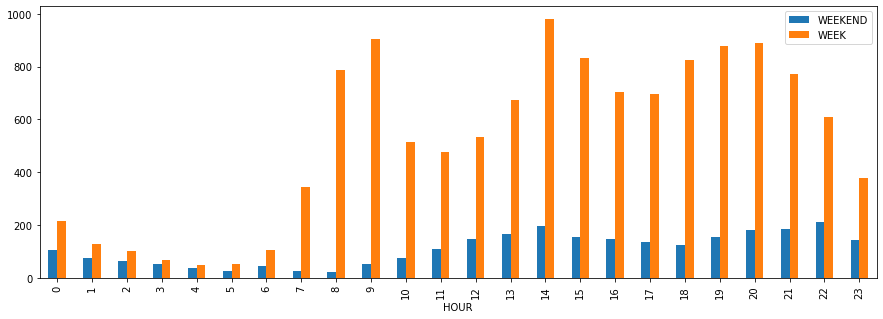

In [17]:
all_week = weekend.copy()
all_week["WEEK"] = week["COUNT"]

all_week.\
    rename(columns={"COUNT": "WEEKEND"}, inplace=False).\
    plot.bar(figsize=(15,5))

As you can see **there's a huge difference** (even visually) when you compare both datasets altogether **with the same scale**.

### Comparing weekend days hour by hour

This time I'm going directly to compare both Saturday and Sunday datasets.

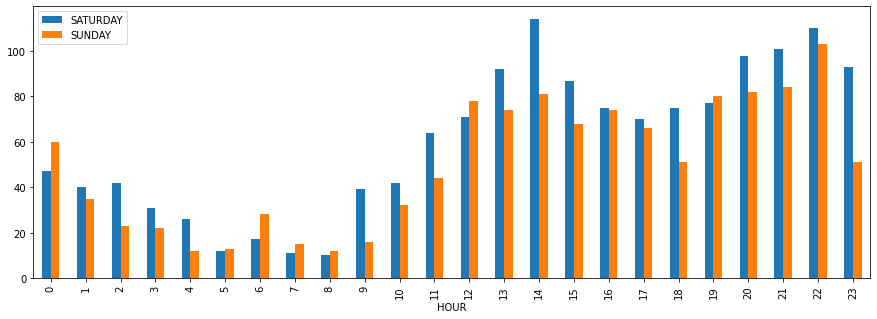

In [18]:
saturday = hs.loc[5]
saturday = pd.DataFrame(saturday.reset_index().groupby("HOUR")["COUNT"].sum()).\
    rename(columns={"COUNT": "SATURDAY"})

sunday = hs.loc[6]
sunday = pd.DataFrame(sunday.reset_index().groupby("HOUR")["COUNT"].sum()).\
    rename(columns={"COUNT": "SUNDAY"})

pd.merge(saturday, sunday, how="inner", on="HOUR").\
    plot.bar(figsize=(15,5))

I can observe that **in general, there're more accidents during Satuday than Sunday**. The exception is the earlier hours on Sunday which I guess corresponds people hanging out and at sunset on Sunday when these people are coming home and some other people are heading work (e.g: bakers).

### Blackspots: Streets with highest rate of aggregated accidents

Which are the streets with the highest number of accidents overtime ?

In [19]:
bs = accidents.copy()
bs.groupby(["CALLE", "DISTRITO"]).\
    size().\
    reset_index(name='COUNT').\
    sort_values("COUNT", ascending=False).\
    head(10).\
    reset_index().\
    drop("index", axis=1)

,CALLE,DISTRITO,COUNT
0,BRAVO MURILLO,TETUAN,145
1,ALCALA,SALAMANCA,123
2,ALCALA,CIUDAD LINEAL,123
3,SERRANO,SALAMANCA,80
4,GRAN VIA,CENTRO,72
5,ARTURO SORIA,CIUDAD LINEAL,72
6,PASEO. CASTELLANA,CHAMARTIN,60
7,FRANCISCO SILVELA,SALAMANCA,58
8,PASEO. CASTELLANA,TETUAN,57
9,JOAQUIN COSTA,CHAMARTIN,56


I can see a clear winner with the **BRAVO MURILLO** street, followed by **ALCALA**. Alcala makes sense to me because it's a really long street spanning different districts, so it's naturally busy all the time. But I have to admit that I wouldn't have said Bravo Murillo, not in a million years.

### Next steps

I'd like to create a probability table in order to answer the question: What is the probability of having an accident at a given district at a given day of the week at a given hour ? That requires some missing numbers I have to get before going any further.

## Resources

- [Accidents in Madrid city](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=7c2843010d9c3610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default) 
- [Vehicles in Spain in 2019 by province](http://www.dgt.es/es/seguridad-vial/estadisticas-e-indicadores/parque-vehiculos/tablas-estadisticas/2019/)